## 0. Imports

In [2]:
import torch
from torch import nn as nn

In [3]:
import os
import xml.etree.ElementTree as ET
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader

In [4]:
import torchvision.transforms as transforms 
import torch.optim as optim

## 1. Conv Neural Network

In [6]:
class CarBrand(nn.Module):
    def __init__(self, num_classes):
        super(CarBrand, self).__init__()
        
        # 'in_channels': color channels in images, since images in dataset are greyscaled, in_channels start from 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 128: comes from "conv3", 124: image size is 300x300, 1: only greyscaled, not RGB
        self.fc1 = nn.Linear(128 * (300//8) * (300//8) * 1, 256)  # Adjust the input size
        #self.fc2_class = nn.Linear(512, num_classes)         
        self.fc2_class = nn.Linear(256, num_classes) 
           
        
    def forward(self, x):
        x = x.unsqueeze(1) #
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)       
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)        
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        brand_pred = self.fc2_class(x)   
        return brand_pred

## 2. Dataset class

In [7]:
class CarBrandDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = [filename for filename in os.listdir(data_dir) if filename.endswith('.jpg')]
    
    def __len__(self):
        return len(self.image_paths)
        
    def __getitem__(self, index):
        image_path = os.path.join(self.data_dir, self.image_paths[index])
        
        xml_path = os.path.splitext(image_path)[0] + '.xml'
        
        image = Image.open(image_path).convert('L') # convert to greyscale
        if self.transform:
            data = (2, 0.5, -10, -0.5, 1.5, 20)
            image = image.transform(image.size, Image.AFFINE, data)
        
        # parse XML
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        # extract label information from XML 
        brand_label_mapping = {
            'bmw': 0,
            'citroen': 1,
            'mercedes': 2,
            'maserati': 3,
            'audi': 4,
            'honda': 5
        }

        for object in  root.findall('object'):
            brand_label_name = object.find('name')
            brand_label_str = brand_label_name.text.strip()  # Clean any extra whitespace
            # print("Extracted label string:", brand_label_str)
            
            brand_label = brand_label_mapping.get(brand_label_str, -1)
            # print("Mapped label:", brand_label) 
            # print("XML Root Tag:", root.tag)
            # print("Final mapped label:", brand_label)

        image_np = np.asarray(image, dtype=np.float32)
        
        return image_np, brand_label

## 3. Read images and .xml files

In [14]:
# Read the image and the XML file
image = cv2.imread('data/1.jpg')
xml_file = open('data/1.xml', 'r')
tree = xml.etree.ElementTree.parse(xml_file)
root = tree.getroot()

# Get the bounding box coordinates
for object in root.findall('object'):
    bndbox = object.find('bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    
    print(f"xmin:{xmin},ymin{ymin},xmax:{xmax},ymax{ymax}")

xmin:22,ymin170,xmax:38,ymax212


## 4. Image Preprocess

In [40]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(300),
    transforms.ToTensor() 
])

## 5. Get ready for training

In [41]:
data_dir = "splitted_data/train"
dataset = CarBrandDataset(data_dir, transform=transform)
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
car_brands: int = 6
num_epochs: int = 10

### 5.1 Training Loop

In [53]:
model = CarBrand(num_classes=car_brands)
criterion_class = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0 ##
    total_samples = 0 ##
    all_predicted_labels = []  # Store all predicted labels
    true_labels = []  # Store all true labels
    
    for images, brand_labels in dataloader:
        optimizer.zero_grad()

        brand_pred = model(images)

        loss_brand = criterion_class(brand_pred, brand_labels)
 
        loss_brand.backward()
        optimizer.step()

        running_loss += loss_brand.item()
        _, predicted = torch.max(brand_pred, 1)  # Get predicted class index ##
        correct_predictions += (predicted == brand_labels).sum().item() ##
        total_samples += brand_labels.size(0) ##

        all_predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(brand_labels.cpu().numpy())
        
    epoch_loss = running_loss / len(dataloader) ##
    epoch_accuracy = correct_predictions / total_samples ##
    
    # print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {running_loss / len(dataloader)}")
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.6f} Accuracy: {epoch_accuracy:.2%}")



C:\Users\Cihan\AppData\Local\Temp\ipykernel_22860\89705713.py:18: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
  image = image.transform(image.size, Image.AFFINE, data)


Epoch [1/10] Loss: 149.747064 Accuracy: 16.75%
Epoch [2/10] Loss: 1.905744 Accuracy: 24.37%
Epoch [3/10] Loss: 1.702682 Accuracy: 27.92%
Epoch [4/10] Loss: 1.366035 Accuracy: 46.70%
Epoch [5/10] Loss: 0.860271 Accuracy: 66.50%
Epoch [6/10] Loss: 0.649375 Accuracy: 79.70%
Epoch [7/10] Loss: 0.337961 Accuracy: 89.85%
Epoch [8/10] Loss: 0.193826 Accuracy: 93.40%
Epoch [9/10] Loss: 0.155901 Accuracy: 94.42%
Epoch [10/10] Loss: 0.021717 Accuracy: 100.00%


NameError: name 'confusion_matrix' is not defined

### 5.2 Confusing Matrix and Loss-Accuracy Graph

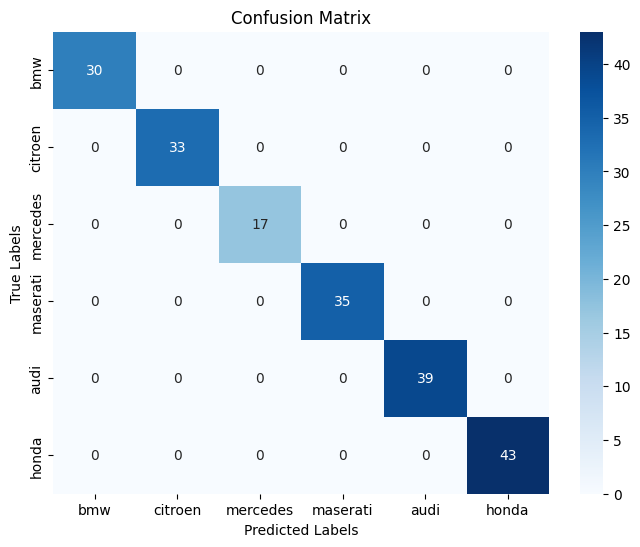

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

brand_label_mapping = {
            'bmw': 0,
            'citroen': 1,
            'mercedes': 2,
            'maserati': 3,
            'audi': 4,
            'honda': 5
        }

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, all_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=brand_label_mapping, yticklabels=brand_label_mapping)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

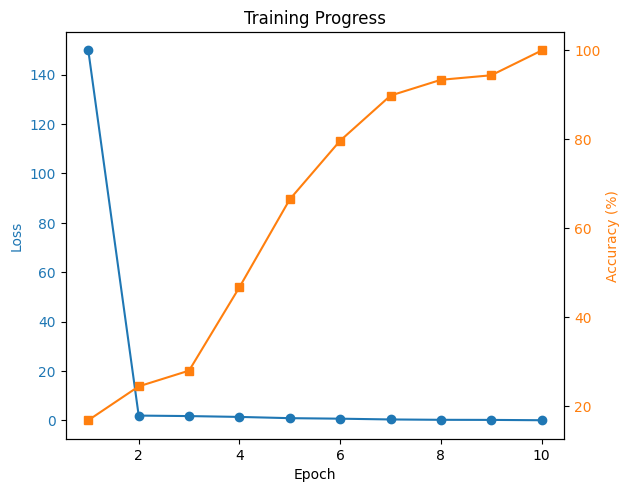

In [56]:
import matplotlib.pyplot as plt

# Data
epochs = list(range(1, 11))
loss_values = [149.747064, 1.905744, 1.702682, 1.366035, 0.860271, 0.649375, 0.337961, 0.193826, 0.155901, 0.021717]
accuracy_values = [16.75, 24.37, 27.92, 46.70, 66.50, 79.70, 89.85, 93.40, 94.42, 100.00]

# Create the plot
fig, ax1 = plt.subplots()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color='tab:blue')
ax1.plot(epochs, loss_values, color='tab:blue', marker='o', label='Loss')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy (%)', color='tab:orange')
ax2.plot(epochs, accuracy_values, color='tab:orange', marker='s', label='Accuracy')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()
plt.title('Training Progress')
plt.show()


## 6. Testing

In [58]:
test_data_dir = "splitted_data/test"
test_dataset = CarBrandDataset(test_data_dir, transform=transform)  # Use the same transform as during training
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
model.eval()  # Set the model to evaluation mode

correct_predictions = 0
total_samples = 0

with torch.no_grad():
    for images, brand_labels in test_dataloader:
        brand_pred = model(images)
        _, predicted = torch.max(brand_pred, 1)
        correct_predictions += (predicted == brand_labels).sum().item()
        total_samples += brand_labels.size(0)

test_accuracy = correct_predictions / total_samples
print(f"Test Accuracy: {test_accuracy:.2%}")


C:\Users\Cihan\AppData\Local\Temp\ipykernel_22860\89705713.py:18: DeprecationWarning: AFFINE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transform.AFFINE instead.
  image = image.transform(image.size, Image.AFFINE, data)


Test Accuracy: 97.94%


### 6.1 Test it with custom images

In [82]:
from PIL import Image
model = CarBrand(num_classes=car_brands)

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

# Load your own image
# image_path = "test_honda.jpg"
# image_path = "test_audi.jpg"
image_path = "test_mercedes.jpg"
image = Image.open(image_path)

# Apply transformations 
input_image = transform(image)
input_image = input_image.view(1, 300, 300)

with torch.no_grad():
    output = model(input_image)
    _, predicted_class = torch.max(output, 1)

# Map the predicted class to its label
brand_label_mapping = {
    0: 'bmw',
    1: 'citroen',
    2: 'mercedes',
    3: 'maserati',
    4: 'audi',
    5: 'honda'
}

predicted_label = brand_label_mapping[predicted_class.item()]
print(f"Predicted brand: {predicted_label}")

Predicted brand: mercedes


## 7. Save the model

In [ ]:
# Save model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'criterion_state_dict': criterion_class.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}

torch.save(checkpoint, 'model_checkpoint.pth')


## 8. Load the model

In [ ]:
# Load model checkpoint
checkpoint = torch.load('model_checkpoint.pth')

# Create a new model instance
loaded_model = CarBrand(num_classes=car_brands)

# Load model state dictionary
loaded_model.load_state_dict(checkpoint['model_state_dict'])

# Create a new criterion instance
loaded_criterion = nn.CrossEntropyLoss()

# Load criterion state dictionary
loaded_criterion.load_state_dict(checkpoint['criterion_state_dict'])

# Create a new optimizer instance
loaded_optimizer = optim.Adam(loaded_model.parameters(), lr=0.001)

# Load optimizer state dictionary
loaded_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
